# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Autoencode](#classifier)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
%load_ext autoreload
%autoreload 2

### Pathways <a name="1pathways"></a>

In [2]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [3]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [4]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (3029950, 110)
Our input array Uy is of shape: (3035459, 110)
Printing a row of Ux: 
 [0.06417897 0.25470302 0.55885671 0.9493     1.38895813 1.83536662
 2.24512906 2.57829978 2.80235851 2.89542637 2.99010086 3.07846599
 3.16237576 3.24272178 3.31993687 3.39424293 3.46575844 3.53454851
 3.60064961 3.66408252 3.72485926 3.7829869  3.83846969 3.89131023
 3.94151015 3.98907053 4.03399206 4.07627523 4.11592037 4.15292772
 4.18729746 4.21902971 4.24812457 4.27458211 4.29840238 4.31958542
 4.33813127 4.35403995 4.36731148 4.37794586 4.38594311 4.39130324
 4.39402626 4.39450555 4.39404578 4.39284058 4.39093435 4.38834725
 4.38508917 4.38116522 4.37657817 4.37132956 4.36542029 4.35885087
 4.3516216  4.34373269 4.33518425 4.32597635 4.31610906 4.3055824
 4.29439639 4.28255106 4.27004643 4.25688248 4.24305925 4.22857672
 4.2134349  4.19763381 4.18117343 4.16405377 4.14627483 4.12783661
 4.10873912 4.08898235 4.06856631 4.04749099 4.02575639 4.00336252
 3.98030938 

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [5]:
size = Ux.shape[0]/25
print("We have run", Ux.shape[0],"simulations with a step of",size)

We have run 3029950 simulations with a step of 121198.0


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [6]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [7]:
ratio_pts = 0.1
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(302500, 110) (302500, 110)


In [8]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

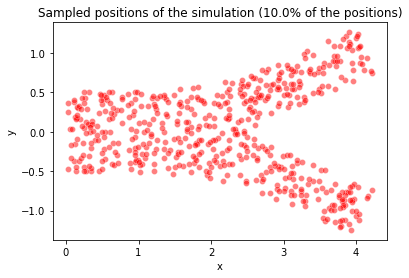

In [9]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a single matrix with dimensions $((2 N_u N_t), N_s)$

In [10]:
print(new_Ux)

[[0.05297715 0.2061886  0.44266392 ... 2.02004071 1.99099906 1.96151397]
 [0.01322163 0.04695252 0.09198472 ... 0.26373287 0.25978999 0.2557881 ]
 [0.04901893 0.19057232 0.40862265 ... 1.83301461 1.80660185 1.77978629]
 ...
 [0.06329908 0.25164429 0.55250989 ... 2.94060993 2.8988906  2.85652978]
 [0.01160936 0.03880894 0.07115106 ... 0.13202943 0.12995503 0.12785035]
 [0.02760381 0.10274274 0.21184031 ... 0.88227332 0.86956985 0.85667256]]


In [11]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(550, 121000)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [12]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

121000


## 3. Auto-encoder  <a name="autoencoder"></a>

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [13]:
# Set seed 
seed = 123
flattened_array_train, flattened_array_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = flattened_array_train, flattened_array_test

print(flattened_array_train.shape)
print(flattened_array_test.shape)

(495, 121000)
(55, 121000)


epoch : 1/30, loss = 10.227451
epoch : 2/30, loss = 10.185932
epoch : 3/30, loss = 10.125174
epoch : 4/30, loss = 10.000943
epoch : 5/30, loss = 9.816714
epoch : 6/30, loss = 9.550444
epoch : 7/30, loss = 9.203073
epoch : 8/30, loss = 8.585593
epoch : 9/30, loss = 7.860481
epoch : 10/30, loss = 7.302458
epoch : 11/30, loss = 6.786944
epoch : 12/30, loss = 6.379237
epoch : 13/30, loss = 6.261069
epoch : 14/30, loss = 6.165189
epoch : 15/30, loss = 6.067967
epoch : 16/30, loss = 5.962169
epoch : 17/30, loss = 5.859931
epoch : 18/30, loss = 5.757855
epoch : 19/30, loss = 5.673641
epoch : 20/30, loss = 5.608814
epoch : 21/30, loss = 5.495934
epoch : 22/30, loss = 5.161887
epoch : 23/30, loss = 4.396667
epoch : 24/30, loss = 3.199801
epoch : 25/30, loss = 1.939162
epoch : 26/30, loss = 1.104422
epoch : 27/30, loss = 0.905134
epoch : 28/30, loss = 0.902117
epoch : 29/30, loss = 0.901401
epoch : 30/30, loss = 0.900915


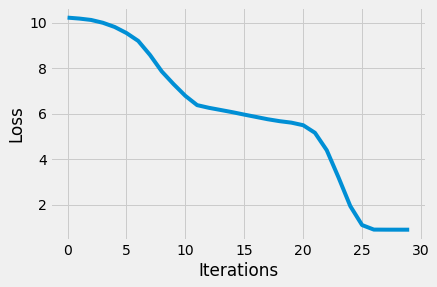

In [14]:
train(flattened_array_train)

In [15]:
test(flattened_array_test)

0.25071517234593654

In [16]:
test(flattened_array_train)

0.23140969663917668

## 4. Passer en 2D 

## 5. Hyper-parameters and physics parameters relationship

## 6. Discussion & conclusion